## GANs

It is a neural network architecture, with the aim of obtaining models capable of generating realistic data, mainly images. They are a class of artificial intelligence algorithms used in unsupervised learning, implemented by a system of two neural networks that compete with each other in a kind of zero-sum game.

The basic architecture of GANs is made up of two neural networks:

* The generator: receives random values at the input (normally obtained from a Gaussian-type distribution) and outputs an image. You can view the random input as a latent representation (or encoding) of the generated image.
* The discriminator: receives an image (real or generated by the generator) at the input and has to decide whether the image is real or false.

## Dataset

MNIST Fashion Dataset, is made up of 60,000 low-resolution images (28 x 28 pixels, black and white) and contains 10 types of clothing (t-shirts, pants, etc).

In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

classes = ("t-shirt", "trousers", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

In [ ]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)
      
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(trainset)

60000

In [ ]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([784]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [ ]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shapem

(torch.Size([32, 784]), torch.Size([32]))

## Images Examples

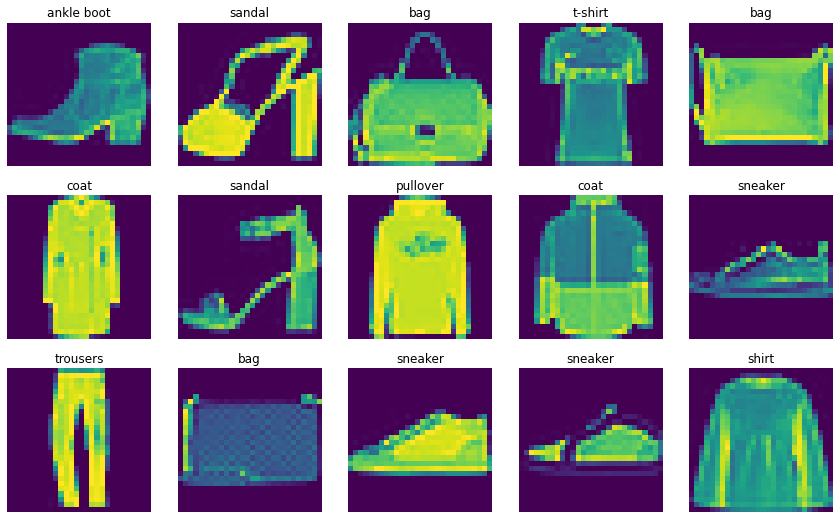

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(28,28).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

## Model

The objective is to train a GAN that is capable of generating images similar to the ones we have in the dataset from random values (noise). For this, we need a generator and a discriminator. For this simple implementation we will use the same architecture for both networks, a Multilayer Perceptron (MLP).

In [ ]:
import torch.nn as nn

def block(n_in, n_out):
    return nn.Sequential(
        nn.Linear(n_in, n_out),
        nn.ReLU(inplace=True)
    )

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.fc1 = block(input_size, 150)
        self.fc2 = block(150, 100)
        self.fc3 = nn.Linear(100, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In this case, the generator will receive a vector with 30 random values and will output a vector of 28 x 28 values (same as the dataset images).

In [ ]:
n_in, n_out = 30, 28*28
generator = MLP(n_in, n_out)

In [ ]:
output = generator(torch.randn(64, 30))
output.shape

torch.Size([64, 784])

Up to this point, our initialized generator generates random images that look nothing like the real thing.

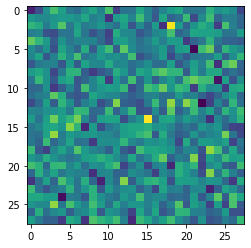

In [ ]:
plt.imshow(output[0].reshape(28,28).detach().numpy())
plt.show()

The discriminator, on the other hand, will receive an image at the input (28 x 28 values) and at the output it will give us a binary classification (true or false).

In [ ]:
discriminator = MLP(28*28, 1)
output = discriminator(torch.randn(64, 28*28))
output.shape

torch.Size([64, 1])

## Trainig

In order to train a GAN effectively, we will do it in two steps:

* In a first phase, we train the discriminator. In each iteration, we will give you a batch composed of real images obtained from the dataset and fake images generated by the generator. We will define a set of labels to 0 for fake images and 1 for real ones. Then, we will optimize the discriminator (using a binary cross-entropy loss function, thus improving its ability to distinguish fake images from real ones.
* In the second phase, we train the generator. At each iteration, we'll give it a random noise composite batch to generate images. These images are introduced in the discriminator, whose outputs (real/false labels) are compared with a set of labels defined as real. We will then optimize the generator (using the same loss function again) so that the generator will update its weights to generate images that fool the discriminator.

In [ ]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCEWithLogitsLoss() if crit == None else crit
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        for X, y in progress_bar(dataloader, parent=mb):
            # X, y = X.to(device), y.to(device)  
            # train the discriminator
            g.eval()
            d.train()
            # generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # discriminator input
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # ground truth for the discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimization
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # train the generator
            g.train()
            d.eval()
            # generate a batch of fake images
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # discriminator outputs
            d_output = d(genenerated_images)
            # ground truth for the generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimization
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))    
        hist['d_loss'].append(np.mean(d_loss))
    return hist

In [ ]:
hist = fit(generator, discriminator, dataloader)

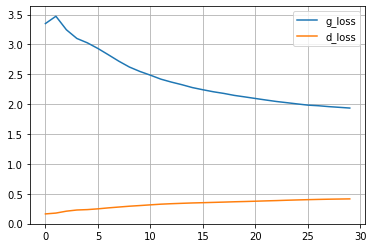

In [ ]:
import pandas as pd 

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

As we can see, the loss of the generator has been decreasing (which is a sign that the training has gone well and the network has learned to generate good images), however, the loss of the discriminator has been increasing. During training, both networks try to fool each other and get better at their task at the same time.

This implies that in the limit where we want a perfect generator, the discriminator will not be able to distinguish real images from fake ones. So, in the context of GANs, an increase in discriminator loss is actually a good sign that everything is working as expected.

## Evaluation

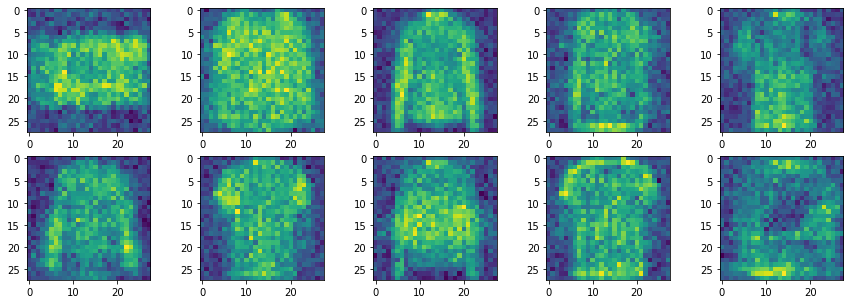

In [ ]:
generator.eval()
with torch.no_grad():
    noise = torch.randn((10, generator.input_size)).to(device)
    generated_images = generator(noise)
    fix, axs = plt.subplots(2, 5, figsize=(15,5))
    i = 0
    for ax in axs:
        for _ax in ax:
            img = generated_images[i].view(28,28).cpu()
            _ax.imshow(img)
            i+=1
    plt.show()